# pki_nn_models.ipynb
The purpose of this file is to a neural network model based on the pki dataset. Since the pki dataset is imbalanced, upsampling will be performed frist followed by the model training 

## Upsampling the data

d_X shape:  (292422, 26)
d_y shape:  (292422, 1)

X_train shape:  (204695, 26)
X_test shape:  (87727, 26)
y_train shape:  (204695, 1)
y_test shape:  (87727, 1)


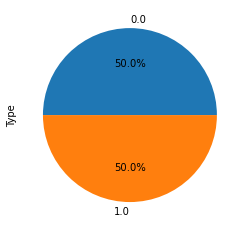

In [2]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

pki_df = pd.read_csv("../MLP2/input/heart_2020_normalized.csv")
x_columns = ['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', \
    'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory', \
    'PhysicalActivity', 'GenHealth', 'SleepTime', 'Asthma', 'KidneyDisease', \
    'SkinCancer', 'American Indian/Alaskan Native', 'Asian', 'Black', \
    'Hispanic', 'Other', 'White', 'No diabetes', 'Borderline diabetes', \
    'Has diabetes', 'Has diabetes (during pregnancy)', 'No diabetes']
y_columns = ['HeartDisease']
target_names = ['No Heart Disease', 'Has Heart Disease']

positive_df = pki_df[pki_df['HeartDisease'] == 1]
negative_df = pki_df[pki_df['HeartDisease'] == 0]

tmp = resample(negative_df, replace=True, n_samples=int(len(negative_df) / 2), random_state=42)
upsample = resample(positive_df, replace=True, n_samples=len(tmp), random_state=42)
upsampled_df = pd.concat([tmp, upsample])
upsampled_df.groupby('HeartDisease').size().plot(kind='pie', y='HeartDisease', label='Type', autopct='%1.1f%%')

u_X = np.c_[upsampled_df[x_columns]]
u_y = np.c_[upsampled_df[y_columns]]

print("d_X shape: ", u_X.shape)
print("d_y shape: ", u_y.shape)

uX_train, uX_test, uy_train, uy_test = train_test_split(u_X, u_y, test_size=0.3, random_state=42)
print("\nX_train shape: ", uX_train.shape)
print("X_test shape: ", uX_test.shape)
print("y_train shape: ", uy_train.shape)
print("y_test shape: ", uy_test.shape)

## Training the MLP Classifier